# Modules

In [1]:
import optical_gating_analysis as OG
import matplotlib.pyplot as plt
import numpy as np
import j_py_sad_correlation as jps
import tifffile as tf
import kalman_filter

data = tf.imread(r"D:\Downloads\Archive\drift_corrected.tif")[sorted]
sads = []
for i in range(data.shape[0]):
    sads.append(jps.sad_with_references(data[i], data))
sads = np.array(sads)

sads = np.delete(sads,range(0,sads.shape[0]**2,(sads.shape[0]+1))).reshape(sads.shape[0],(sads.shape[1]-1))
plt.figure(figsize = (30,30))
plt.imshow(sads, interpolation = "none")
plt.show()

# Run OOG

In [2]:
data_src = r"D:\Downloads\Archive\2023-10-30 2hpi_fli1 fish_8_Michellevid\Brightfield - Prosilica\*tif"
#data_src = r"D:\Downloads\Archive\drift_corrected.tif"

In [3]:
oog = OG.BasicOpticalGating()
oog.sequence_manager.set_source(data_src)
oog.sequence_manager.skip_frames = 0
oog.sequence_manager.set_reference_sequence(r"D:\Downloads\Archive\2023-10-30 2hpi_fli1 fish_8_Michellevid\ref-frames-2023-10-30-17.08.39\*tif")
oog.sequence_manager.reference_period = 36.782587
oog.run()

Setting source to D:\Downloads\Archive\2023-10-30 2hpi_fli1 fish_8_Michellevid\Brightfield - Prosilica\*tif
Loading reference sequence from D:\Downloads\Archive\2023-10-30 2hpi_fli1 fish_8_Michellevid\ref-frames-2023-10-30-17.08.39\*tif
Getting SADs
Getting phases


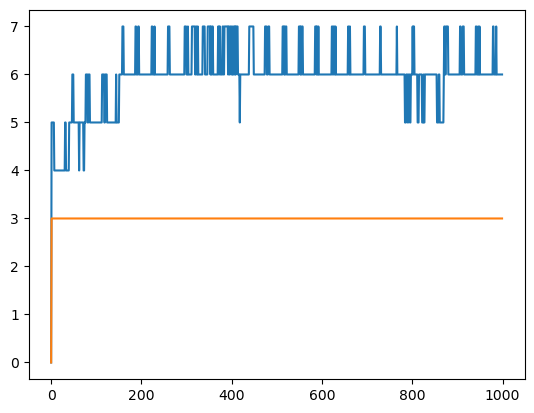

In [4]:
plt.plot(oog.drifts)

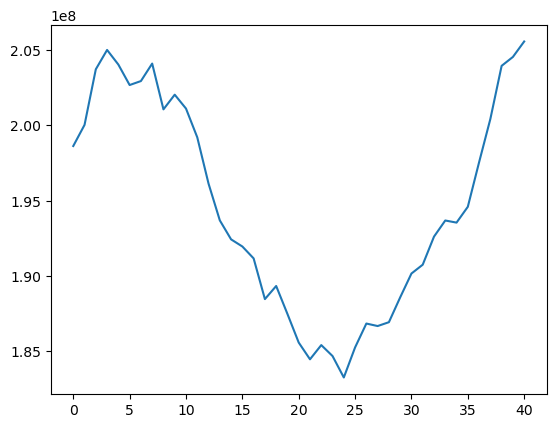

In [5]:
plt.plot(oog.sads[50])

# Find locations with large phase jumps

In [6]:
lpj_locations = np.where(np.abs(oog.delta_phases) > 2 * np.std(oog.delta_phases))

In [7]:
print(lpj_locations[0])

[  0  18  19  22  27  37  42  49  54  57  60  85 122 126 128 131 145 151
 159 163 169 182 189 191 204 218 224 240 255 261 276 290 294 298 301 306
 316 331 334 339 342 347 351 363 367 368 370 371 378 380 388 399 403 406
 411 416 419 424 434 441 443 447 452 458 470 478 483 488 494 508 514 517
 518 520 531 544 558 565 580 584 587 590 601 615 619 631 636 659 660 667
 670 672 687 694 703 706 708 722 730 733 739 741 743 756 764 766 770 775
 778 782 791 793 797 799 803 804 811 820 827 834 836 838 841 847 849 853
 855 862 863 869 872 876 882 885 890 900 905 910 913 919 921 923 935 943
 948 956 972 974 977 979 983 996]


# Run KF but don't use phase estimates during large phase jumps

In [8]:
kf_phases = []
kf = kalman_filter.KalmanFilter.constant_velocity_2(0.1,1,1,[oog.unwrapped_phases[0] % (2 * np.pi),oog.delta_phases[0]],np.diag([100,100]))
for i in range(oog.phases.shape[0]):
    kf.predict()
    if i not in lpj_locations[0] - 1:
        kf_phases.append(kf.update(oog.unwrapped_phases[i])[0])
    else:
        kf_phases.append(kf.x[0])

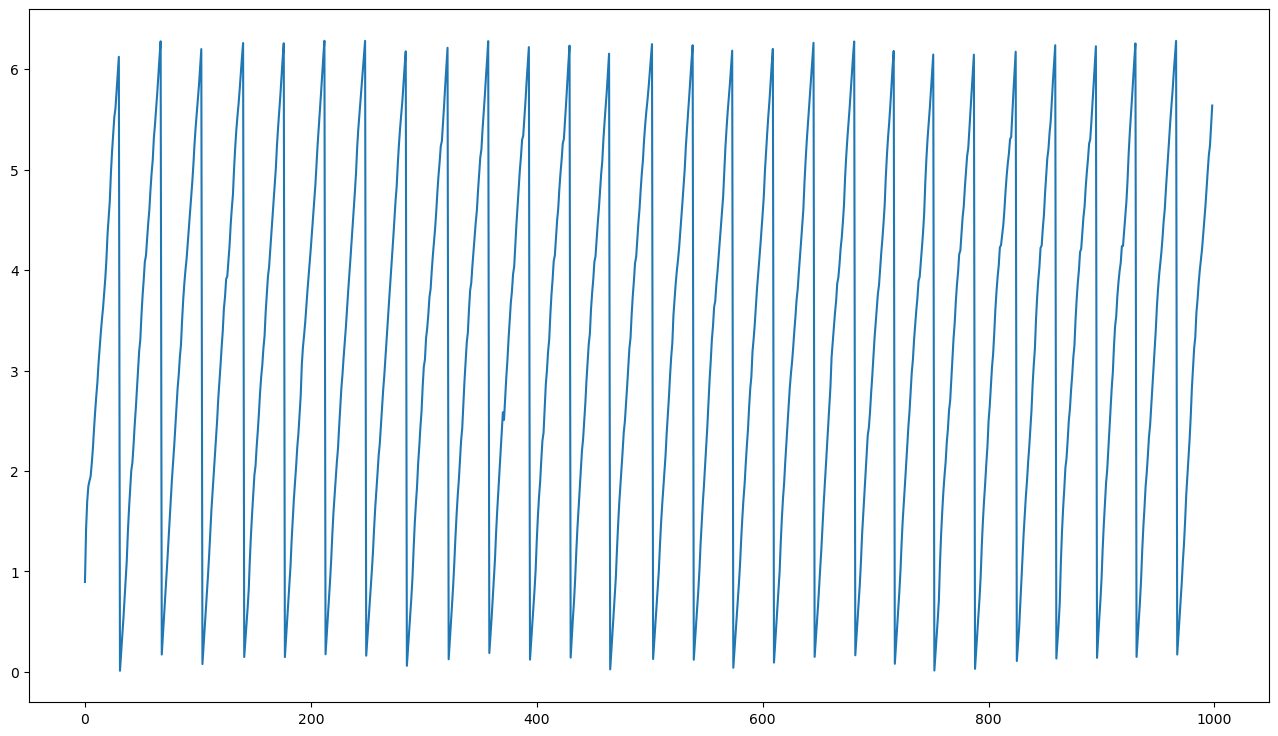

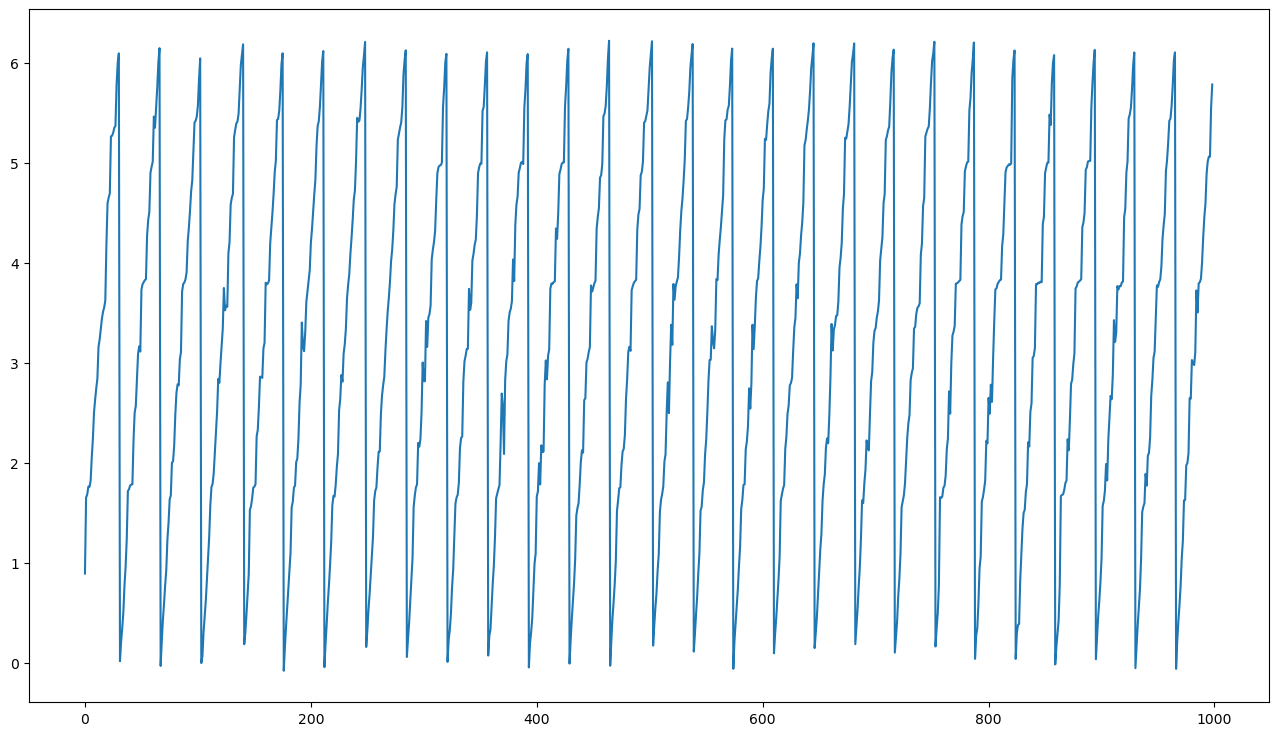

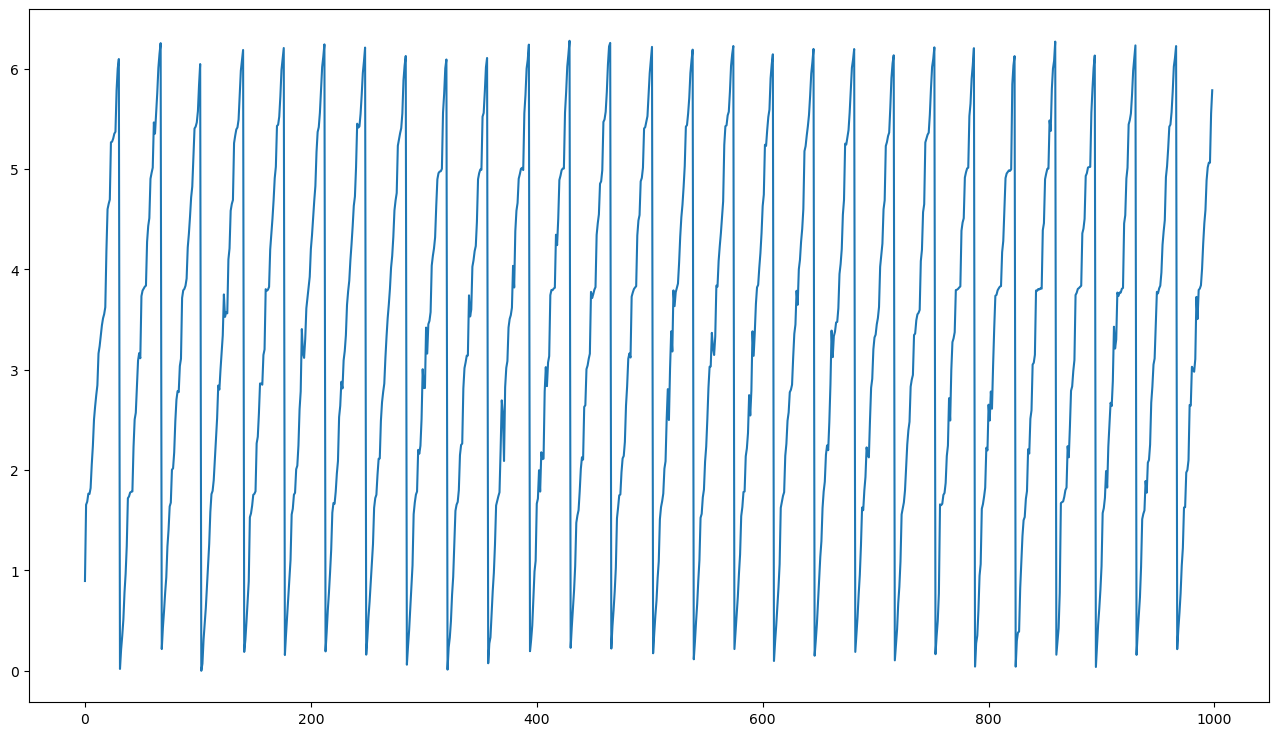

In [9]:
plt.figure(figsize = (16,9))
plt.plot(np.array(kf_phases) % (2 * np.pi))
plt.show()
plt.figure(figsize = (16,9))
plt.plot(oog.phases)
plt.show()
plt.figure(figsize = (16,9))
plt.plot(oog.unwrapped_phases % (2 * np.pi))
plt.show()

# Run sort

In [10]:
sorted_kf = np.argsort(np.array(kf_phases) % (2 * np.pi))
sorted = np.argsort(oog.unwrapped_phases % (2 * np.pi))

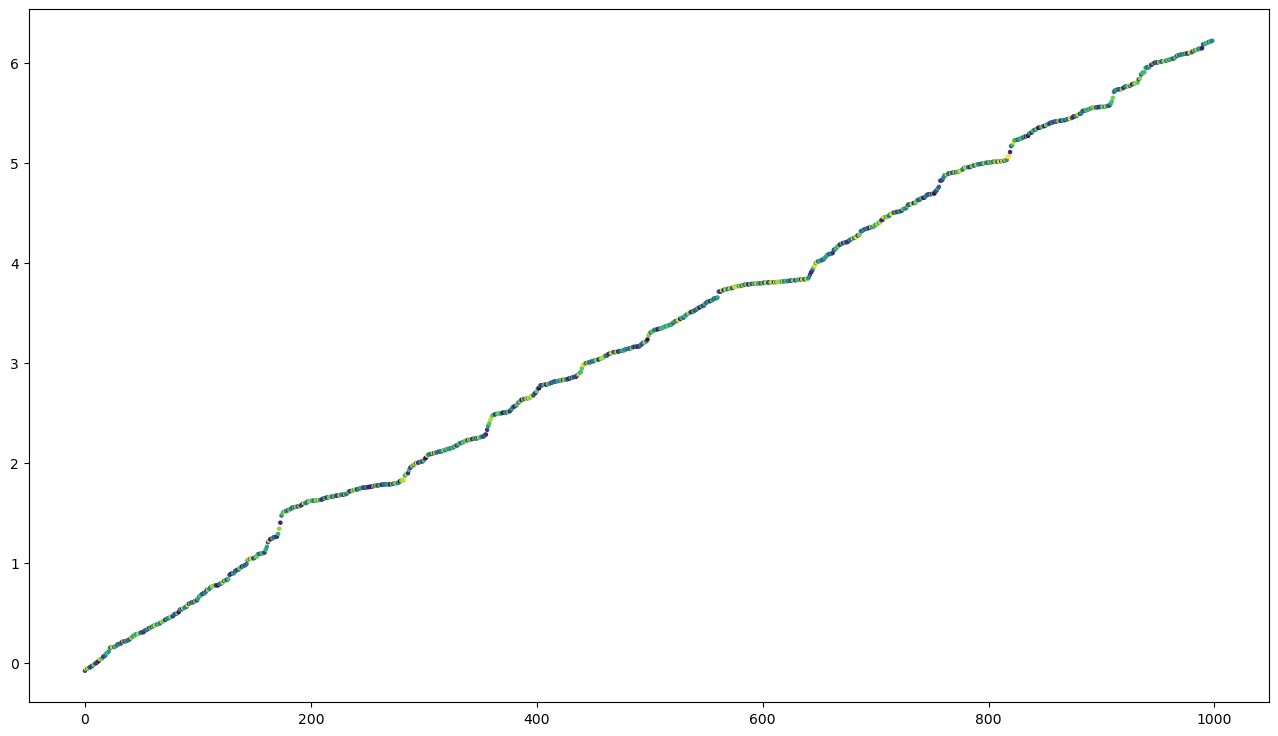

In [24]:
sorted = np.argsort(oog.phases)
plt.figure(figsize = (16,9))
plt.scatter(range(oog.phases.shape[0]), oog.phases[sorted], c = oog.unwrapped_phases[sorted], s = 5)
plt.show()

# Save

In [12]:
data = OG.SequenceManager.load_tif(data_src)
tf.imwrite(r"D:\Downloads\Archive\sorted_kf.tif", data[sorted_kf])
tf.imwrite(r"D:\Downloads\Archive\sorted.tif", data[sorted])


In [13]:
print(data.shape[0])
print(sorted.shape)

1000
(999,)


In [14]:
diffs = []
diffs_kf = []

for i in range(1, data.shape[0] - 1):
    diffs.append(np.sum(np.abs(data[sorted][i] - data[sorted][i - 1])))
    diffs_kf.append(np.sum(np.abs(data[sorted_kf][i] - data[sorted_kf][i - 1])))

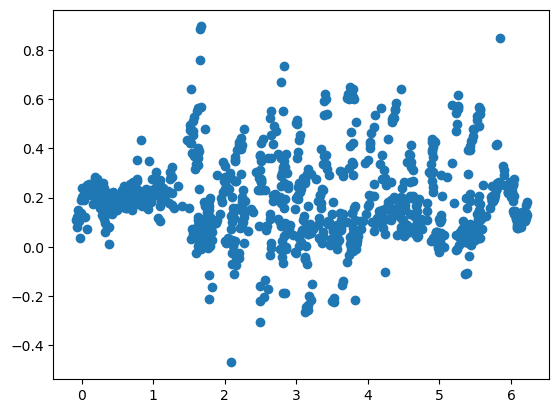

In [15]:
plt.scatter(oog.phases[1::], oog.delta_phases)

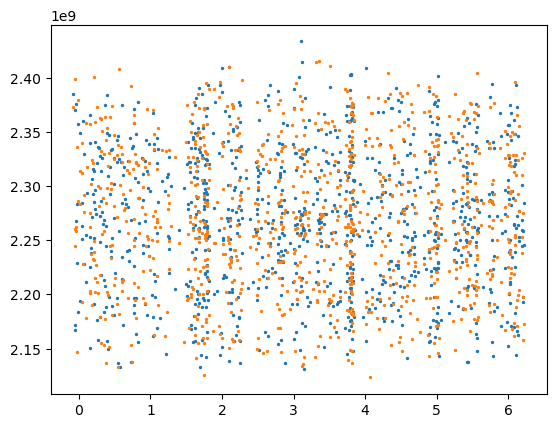

In [16]:
plt.scatter(oog.phases[sorted][1::], diffs, s = 2)
plt.scatter(oog.phases[sorted][1::], diffs_kf, s = 2)
plt.show()

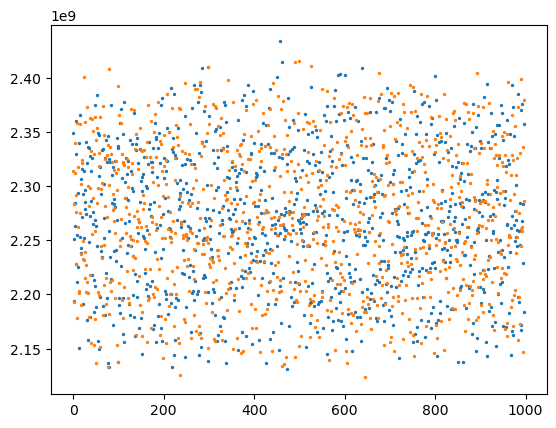

In [17]:
plt.scatter(range(len(diffs)), diffs, s = 2)
plt.scatter(range(len(diffs)), diffs_kf, s = 2)
plt.show()

In [18]:
print(np.std(diffs))
print(np.std(diffs_kf))

64246821.80520116
65322827.73796037
